# Automated Bug Priority Predictor

## Overview
This project aims to develop a machine learning model that predicts the **priority level of software bug reports** based on their text descriptions and metadata.
By automating the triage process, software teams can save time and focus on resolving critical issues faster.

**Datasets:** ISEC Data Challenge https://www.kaggle.com/competitions/isec-sdc-2025/overview

---

# 01 Exploration Data Analysis

## Objective
Explore and clean the data to prepare it for model training in the next phase.

## Notebook Goals
1. Load and inspect the dataset.
2. Understand column types and distribution.
3. Handle missing values and duplicates.
4. Clean and normalize text fields (tokenization, stopwords, lemmatization).
5. Prepare a clean dataset for feature extraction and modeling

## Imports and Setup

In [249]:
# Standard data libraries
import pandas as pd
import numpy as np

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

# Export precessed DataFrame
import joblib

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rusty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rusty\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [250]:
train_df = pd.read_csv("../../data/raw/train.csv")
test_df = pd.read_csv("../../data/raw/test.csv")

In [296]:
train_df

,Issue_id,Component,Title,Description,Status,Resolution,Priority,Text
0,1700,Layout,font size 9px rounded down to 8px {font} {ll},There is a piece of code in the Windows GFX that rounds the font size in the; same way as Netscape 4.X. The problem is that this code ends up rounding 9px; down to 8px; which is illegible.,VERIFIED,FIXED,0,font size 9px rounded down to 8px {font} {ll} There is a piece of code in the Windows GFX that rounds the font size in the; same way as Netscape 4.X. The problem is that this code ends up rounding...
1,7991,Plug-ins,Land OOP plugins in mozilla-central (preffed off),We need to land OOP plugins in mozilla-central; preffed off by default. There are some blockers well need to deal with first.,RESOLVED,FIXED,0,Land OOP plugins in mozilla-central (preffed off) We need to land OOP plugins in mozilla-central; preffed off by default. There are some blockers well need to deal with first.
2,1150,XPCOM,XP-COM Proxy code crashes when trying to AutoProxy parameters without a typelibrary,(This bug imported from BugSplat; Netscapes internal bugsystem. It; was known there as bug #358181; http://scopus.netscape.com/bugsplat/show_bug.cgi?id=358181; Imported into Bugzilla on 07/15/99 ...,VERIFIED,FIXED,0,XP-COM Proxy code crashes when trying to AutoProxy parameters without a typelibrary (This bug imported from BugSplat; Netscapes internal bugsystem. It; was known there as bug #358181; http://scop...
3,6143,XUL,crash setting display:none on grid rows [@ nsGrid::GetPrefRowHeight],User-Agent: Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.8b5) Gecko/20051017 Firefox/1.4.1; Build Identifier: Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.8b5) Gecko/20051017...,VERIFIED,FIXED,0,crash setting display:none on grid rows [@ nsGrid::GetPrefRowHeight] User-Agent: Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.8b5) Gecko/20051017 Firefox/1.4.1; Build Identifier: Moz...
4,5952,Networking,limit the memory cache to a reasonable value,I have 1GB of RAM; so Im using 31MB of memory cache (b/c of the changes in bug; 105344). But it takes a very long time to actually fill up 31MB of memory cache; (often around +100MB VM size); I t...,VERIFIED,FIXED,0,limit the memory cache to a reasonable value I have 1GB of RAM; so Im using 31MB of memory cache (b/c of the changes in bug; 105344). But it takes a very long time to actually fill up 31MB of memo...
...,...,...,...,...,...,...,...,...
52989,53192,Team,Replicate functionality (1GGP770),In regular use; it is often necessary to be able to copy project version from a repository to another one.; Currently this is really difficult (have to manually to the source repository; then add ...,RESOLVED,WONTFIX,4,Replicate functionality (1GGP770) In regular use; it is often necessary to be able to copy project version from a repository to another one.; Currently this is really difficult (have to manually t...
52990,53717,CSS,[charset]Improve @charset parsing in CSSLoaderImpl::SetCharset,Separated from bug 72658.; ; http://lxr.mozilla.org/seamonkey/source/content/html/style/src/nsCSSLoader.cpp#1607; ; Quoted from bug 72658.; ; > ------- Additional Comments From David Baron 2001-05...,RESOLVED,FIXED,4,[charset]Improve @charset parsing in CSSLoaderImpl::SetCharset Separated from bug 72658.; ; http://lxr.mozilla.org/seamonkey/source/content/html/style/src/nsCSSLoader.cpp#1607; ; Quoted from bug 7...
52991,53242,Other,iCab Profile Migrator,.,RESOLVED,WONTFIX,4,iCab Profile Migrator .
52992,53682,DOM,The tableSectionElement.ch doesnt have a default value of .,Overview Description: ; The tableSectionElement.ch should have a default value of . but it doesnt; ; Steps to Reproduce: ; - See attached testcase; ; Actual Results: ; The value is empty; ; Expect...,VERIFIED,FIXED,4,The tableSectionElement.ch doesnt have a default value of . Overview Description: ; The tableSectionElement.ch should have a default value of . but it doesnt; ; Steps to Reproduce: ; - See attache...


In [252]:
train_df.shape

(52994, 7)

In [253]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52994 entries, 0 to 52993
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Issue_id     52994 non-null  int64 
 1   Component    52994 non-null  object
 2   Title        52994 non-null  object
 3   Description  52602 non-null  object
 4   Status       52994 non-null  object
 5   Resolution   52994 non-null  object
 6   Priority     52994 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.8+ MB


In [254]:
for col in ["Component", "Status", "Resolution"]:
  print("Column:", col)
  print("Unique values:", train_df[col].unique())
  print("Value count:", train_df[col].value_counts())

Column: Component
Unique values: ['Layout' 'Plug-ins' 'XPCOM' 'XUL' 'Networking: Cache' 'File Handling'
 'Untriaged' 'Security: UI' 'XPConnect' 'SocialAPI: Providers'
 'Layout: Form Controls' 'JavaScript Engine' 'Editor' 'DOM'
 'Event Handling' 'Embedding: APIs' 'Layout: Tables' 'Document Navigation'
 'Layout: Block and Inline' 'Geolocation' 'Graphics' 'DOM: Events'
 'General' 'Printing: Output' 'HTML: Parser' 'Tracking' 'Networking'
 'Installer: XPInstall Engine' 'Disability Access APIs' 'Profile: BackEnd'
 'HTML: Form Submission' 'Layout: Misc Code' 'Security: CAPS'
 'Build Config' 'Widget: Cocoa' 'WebRTC: Audio/Video' 'Spelling checker'
 'DOM: Apps' 'WebRTC: Networking' 'Selection' 'Security: PSM'
 'Developer Tools: Debugger' 'XML' 'DOM: Core & HTML' 'XBL'
 'Networking: HTTP' 'CSS Parsing and Computation' 'Layout: HTML Frames'
 'Print Preview' 'Developer Tools: Console' 'WebRTC' 'PDF Viewer'
 'Layout: R & A Pos' 'UI' 'WebRTC: Signaling' 'Layout: Floats' 'Security'
 'Networking: Cook

In [255]:
train_df.isnull().sum()

Issue_id         0
Component        0
Title            0
Description    392
Status           0
Resolution       0
Priority         0
dtype: int64

In [256]:
train_df[train_df["Description"].isnull()]

,Issue_id,Component,Title,Description,Status,Resolution,Priority
76,8969,WebRTC: Audio/Video,Crash in WebRTC Assertion failure: !other->mOtherDirection;,NaN,RESOLVED,WORKSFORME,0
202,132,Developer Tools: Graphic Commandline and Toolbar,GCLI should include param group names in help text,NaN,RESOLVED,FIXED,0
229,9124,Security: PSM,Intermittent test_bug339494.xhtml | application terminated with exit code 1536 (from Assertion failure: ss->ssl3.hs.ws == wait_new_session_ticket || ss->ssl3.hs.ws == wait_change_cipher || ss->ssl...,NaN,RESOLVED,FIXED,0
233,7396,JavaScript Engine,TM: Dont assert that global object cant grow additional properties if none are used by any trace and we dont check for global shape mismatches.,NaN,RESOLVED,FIXED,0
241,8448,XPConnect,Move nodePrincipal; documentURIObject; and baseURIObject onto XrayWrapper and remove from nsDOMClassInfo,NaN,RESOLVED,FIXED,0
...,...,...,...,...,...,...,...
51982,53399,Bookmarks & History,practice123,NaN,RESOLVED,INVALID,4
52138,54308,Graphics: Layers,Graphics of page are not working properly,NaN,RESOLVED,INVALID,4
52145,54197,JavaScript Engine,TM: Avoid pusha/popa inside assembly (icc crashes),NaN,RESOLVED,FIXED,4
52203,53572,XPCOM,RFE: xpidl -m js,NaN,RESOLVED,WONTFIX,4


In [257]:
train_df[train_df["Title"].isnull()]


,Issue_id,Component,Title,Description,Status,Resolution,Priority


In [258]:
train_df["Description"] = train_df["Description"].fillna('')

In [259]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52994 entries, 0 to 52993
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Issue_id     52994 non-null  int64 
 1   Component    52994 non-null  object
 2   Title        52994 non-null  object
 3   Description  52994 non-null  object
 4   Status       52994 non-null  object
 5   Resolution   52994 non-null  object
 6   Priority     52994 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.8+ MB


In [260]:
train_df.isnull().sum()

Issue_id       0
Component      0
Title          0
Description    0
Status         0
Resolution     0
Priority       0
dtype: int64

In [261]:
train_df["Text"] = train_df["Title"].str.strip() + " " + train_df["Description"].str.strip()

In [262]:
duplicates = train_df[train_df.duplicated(subset=["Text", "Priority"], keep=False)]
print("Number of duplicate rows: ", duplicates.shape[0])

Number of duplicate rows:  383


In [263]:
duplicates.head()

,Issue_id,Component,Title,Description,Status,Resolution,Priority,Text
4291,482,JavaScript Engine,Bogus property is not defined errors,The lookup code for the JavaScript property cache is wrong. False cache hits are possible when a property is cached as PROP_NOT_FOUND. To the user; the bug manifests itself as bogus property is no...,VERIFIED,INVALID,0,Bogus property is not defined errors The lookup code for the JavaScript property cache is wrong. False cache hits are possible when a property is cached as PROP_NOT_FOUND. To the user; the bug man...
6297,667,HTML: Parser,Parser freeze,Program freezes while loading page.,VERIFIED,FIXED,0,Parser freeze Program freezes while loading page.
6680,483,JavaScript Engine,Bogus property is not defined errors,The lookup code for the JavaScript property cache is wrong. False cache hits are possible when a property is cached as PROP_NOT_FOUND. To the user; the bug manifests itself as bogus property is no...,VERIFIED,FIXED,0,Bogus property is not defined errors The lookup code for the JavaScript property cache is wrong. False cache hits are possible when a property is cached as PROP_NOT_FOUND. To the user; the bug man...
6881,668,HTML: Parser,Parser freeze,Program freezes while loading page.,VERIFIED,FIXED,0,Parser freeze Program freezes while loading page.
10109,18455,Printing: Setup,print error,test problem for demo,RESOLVED,INVALID,1,print error test problem for demo


In [264]:
# Removing duplicate but keeping first occurrance
train_df = train_df.drop_duplicates(subset='Text', keep='first')
print("Dataset shape after removing duplicates: ", train_df.shape)

Dataset shape after removing duplicates:  (52767, 8)


In [265]:
train_df.shape

(52767, 8)

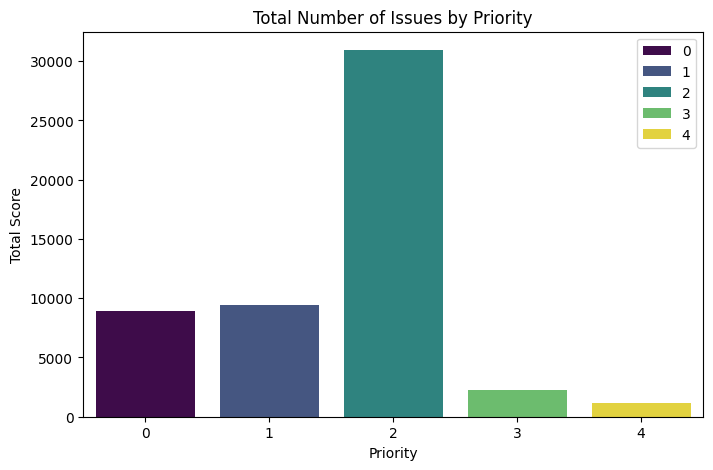

In [266]:
priority_dict = train_df["Priority"].value_counts().to_dict()
plt.figure(figsize=(8,5))
sns.barplot(
  x=list(priority_dict.keys()), 
  y=list(priority_dict.values()), 
  hue=list(priority_dict.keys()),
  palette="viridis"
)
plt.title("Total Number of Issues by Priority")
plt.xlabel("Priority")
plt.ylabel("Total Score")
plt.show()

In [267]:
pd.crosstab(train_df["Component"], train_df["Priority"])

Priority,0,1,2,3,4
Component,,,,,
Account Manager,14,5,6,1,1
Address Book,3,1,5,1,1
Bookmarks & History,9,219,169,122,36
Build Config,57,51,37,6,15
CSS Parsing and Computation,223,398,920,112,34
...,...,...,...,...,...
XUL,436,483,3002,166,67
jemalloc,3,0,0,0,0
js-ctypes,15,2,2,0,0


In [268]:
train_df["Priority"].value_counts()

Priority
2    30944
1     9405
0     8941
3     2286
4     1191
Name: count, dtype: int64

In [269]:
grouped = train_df.groupby("Priority")["Text"].apply(lambda x: np.mean([len(t.split()) for t in x]))
grouped

Priority
0    125.144279
1    108.581393
2    110.746348
3    103.597988
4    151.818640
Name: Text, dtype: float64

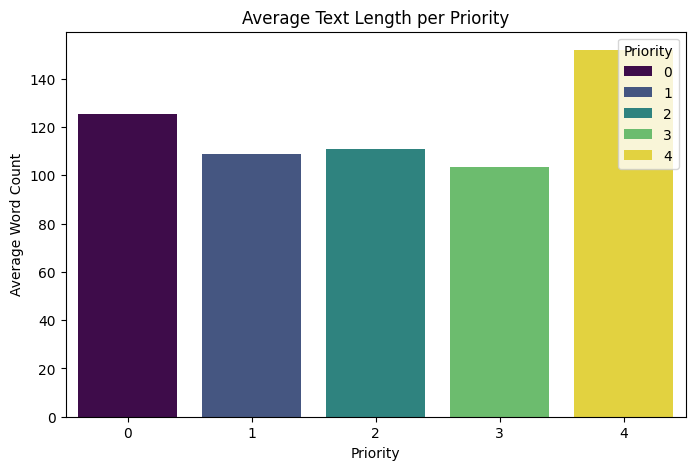

In [270]:
plt.figure(figsize=(8,5))
sns.barplot(
  x=grouped.index, 
  y=grouped.values,
  hue=grouped.index,
  palette="viridis"
)
plt.title("Average Text Length per Priority")
plt.xlabel("Priority")
plt.ylabel("Average Word Count")
plt.show()

In [271]:
# Create a DataFrame with number of words per title, description, and combined text
text_lengths_df = pd.DataFrame()
text_lengths_df["Title_Length"] = train_df["Title"].apply(lambda x: len(x.split()) if pd.notnull(x) else 0 )
text_lengths_df["Description_Length"] = train_df["Description"].apply(lambda x: len(x.split()) if pd.notnull(x) else 0 )
text_lengths_df["Text_Length"] = train_df["Text"].apply(lambda x: len(x.split()) if pd.notnull(x) else 0 )

text_lengths_df.describe()

,Title_Length,Description_Length,Text_Length
count,52767.000000,52767.000000,52767.000000
mean,7.889647,105.527811,113.417458
std,3.376495,154.656207,154.916466
min,1.000000,0.000000,1.000000
25%,6.000000,39.000000,46.000000
50%,8.000000,71.000000,79.000000
75%,10.000000,121.000000,129.000000
max,46.000000,4122.000000,4129.000000


In [272]:
def plot_histogram(text_df, column_name):
  plt.figure(figsize=(8,5))
  plt.hist(text_df[column_name], bins=50, color='skyblue', edgecolor='black')
  plt.title(f"Distribution of {column_name}")
  plt.xlabel("Number of Words")
  plt.ylabel("Frequency")
  plt.show()

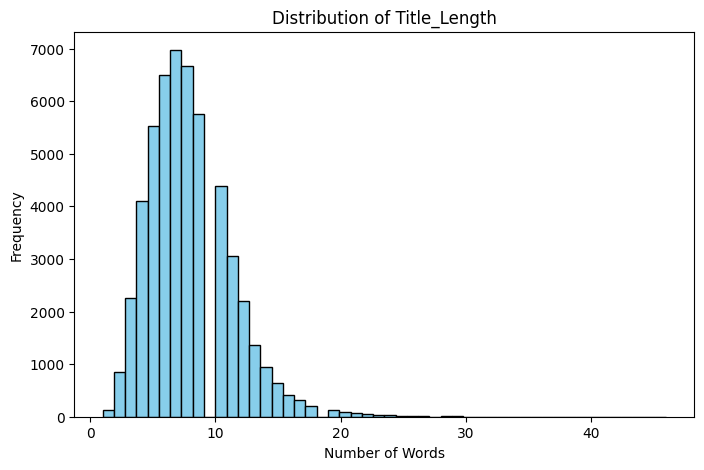

In [273]:
plot_histogram(text_lengths_df, "Title_Length")

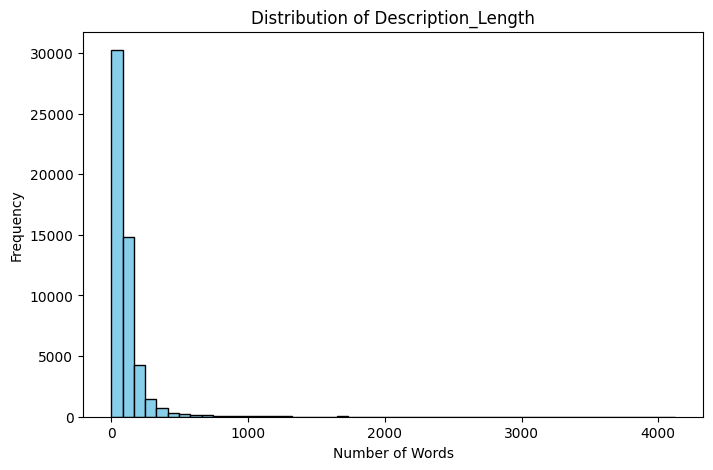

In [274]:
plot_histogram(text_lengths_df, "Description_Length")

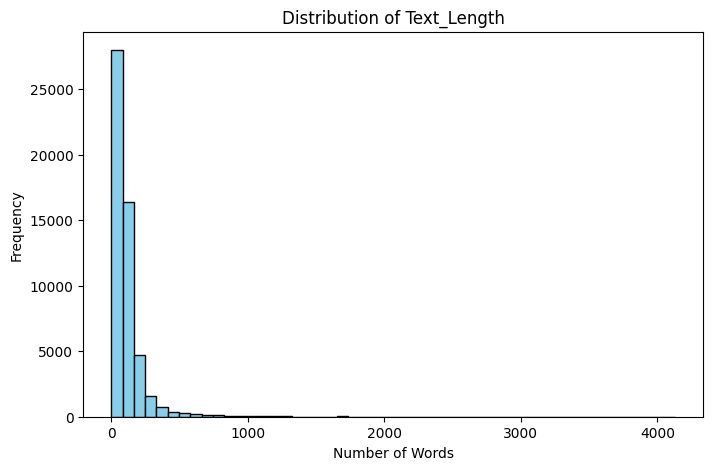

In [275]:
plot_histogram(text_lengths_df, "Text_Length")

In [276]:
text_lengths = text_lengths_df["Text_Length"]
max_lengths = np.percentile(text_lengths, 95)
print("95th percentile of text length: ", max_lengths)

95th percentile of text length:  294.6999999999971


In [277]:
median_length = np.median(text_lengths)
max_length = np.max(text_lengths)
min_length = np.min(text_lengths)

print("Median length: ", median_length)
print("Max length: ", max_length)
print("Min length: ", min_length)

Median length:  79.0
Max length:  4129
Min length:  1


In [278]:
# Number of rows in text with less than equal to 296
num_text_to_target = sum(text_lengths_df["Text_Length"] <= 296)
percentage_of_target = (num_text_to_target / len(text_lengths_df)) * 100

print("Number of rows less than equal to target token limit: ", num_text_to_target)
print("Percentage of rows to the target token limit: ", percentage_of_target)

Number of rows less than equal to target token limit:  50168
Percentage of rows to the target token limit:  95.07457312335362


Set tokenizer max_length = 296, this will truncate outlier (4129)

In [279]:
stop_words = set(stopwords.words('english'))  # removes stopwords
domain_stopwords = {"issue", "ticket", "problem"}
stop_words = stop_words.union(domain_stopwords)
lemmatizer = WordNetLemmatizer()

def clean_text(text):
  """
  Cleans and preprocess text

  Args:
      text (str): The text that gets cleaned
  """
  
  text = str(text).lower()
  text = text.replace('_', ' ')
  text = re.sub(r"\s+", " ", text).strip()              # removes extra spaces
  text = re.sub(r"http\S+|www\S+|https\S+", "", text)   # removes urls
  text = re.sub(r"[^a-z0-9\s]", "", text)               # removes punctuation
  tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words and len(word) > 2]
  return " ".join(tokens)

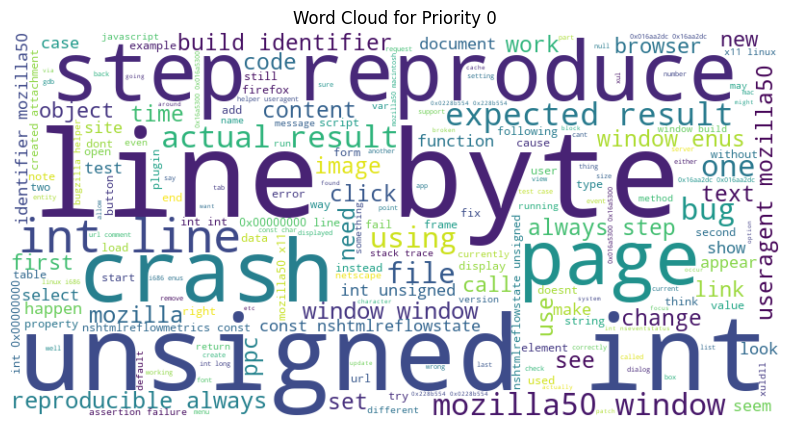

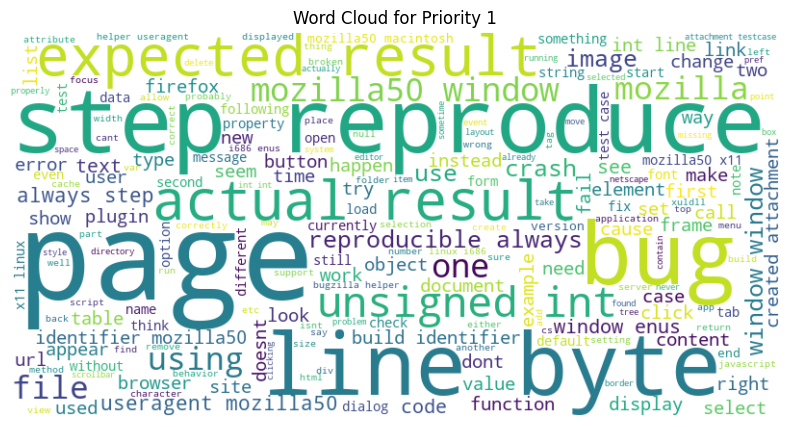

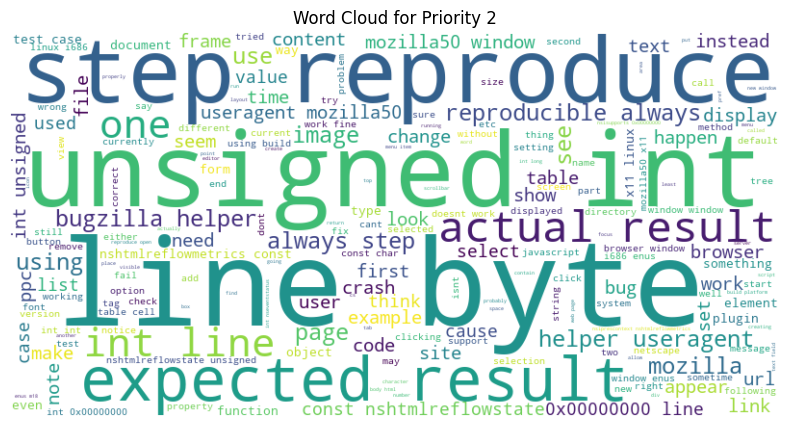

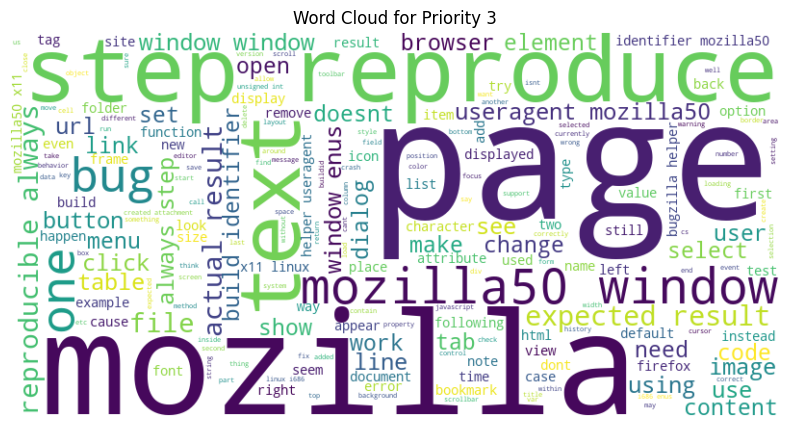

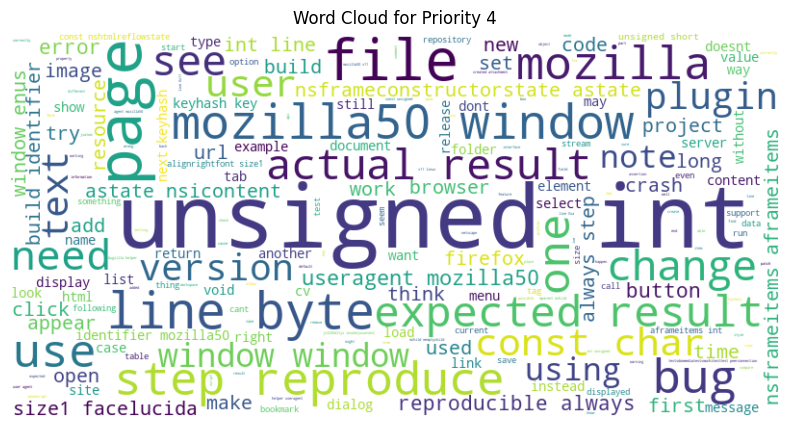

In [280]:
clean_text_series = train_df["Text"].apply(clean_text)
priority_list = train_df["Priority"].unique()

for priority_value in priority_list:
  subset_indices = train_df["Priority"] == priority_value
  combined_text = " ".join(clean_text_series[subset_indices].tolist())
  
  wc = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(combined_text)

  plt.figure(figsize=(10,5))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.title(f"Word Cloud for Priority {priority_value}")
  plt.show()

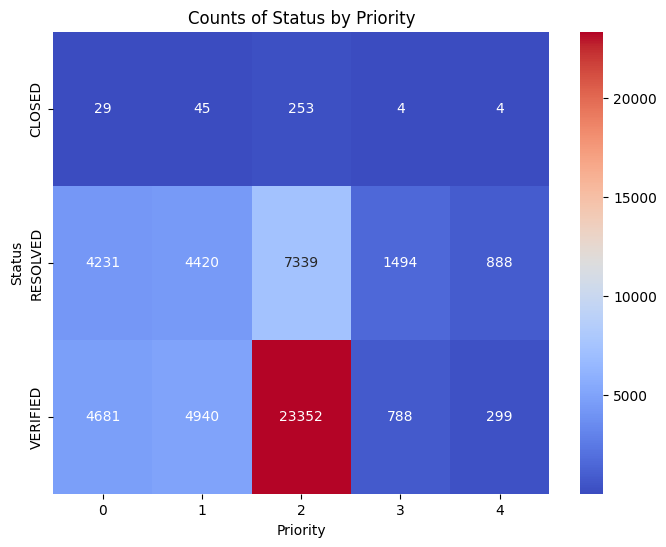

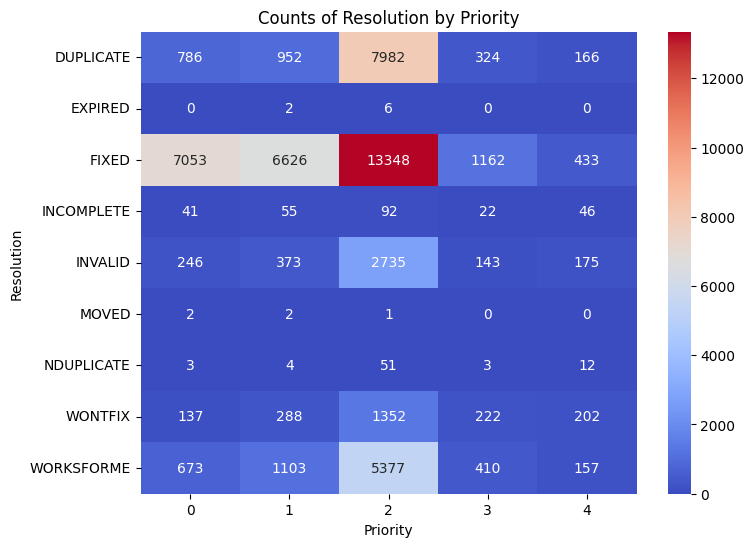

In [281]:
for col in ["Status", "Resolution"]:
  ct = pd.crosstab(train_df[col], train_df["Priority"])
  plt.figure(figsize=(8,6))
  sns.heatmap(ct, annot=True, fmt="d", cmap="coolwarm")
  plt.title(f"Counts of {col} by Priority")
  plt.ylabel(col)
  plt.xlabel("Priority")
  plt.show()

In [282]:
num_unique_components = len(train_df["Component"].unique())
num_unique_components

183

In [283]:
component_counts = train_df["Component"].value_counts()
component_counts.head(20)

Component
Layout                         6105
XUL                            4154
Editor                         3025
JavaScript Engine              2496
Networking                     2407
Layout: Tables                 2021
Layout: Form Controls          1805
CSS Parsing and Computation    1687
HTML: Parser                   1649
Plug-ins                       1544
Security: UI                   1538
DOM: Core & HTML               1509
Internationalization           1434
XPCOM                          1345
Event Handling                 1040
DOM                             995
ImageLib                        803
HTML: Form Submission           786
Tracking                        743
Installer: XPInstall Engine     712
Name: count, dtype: int64

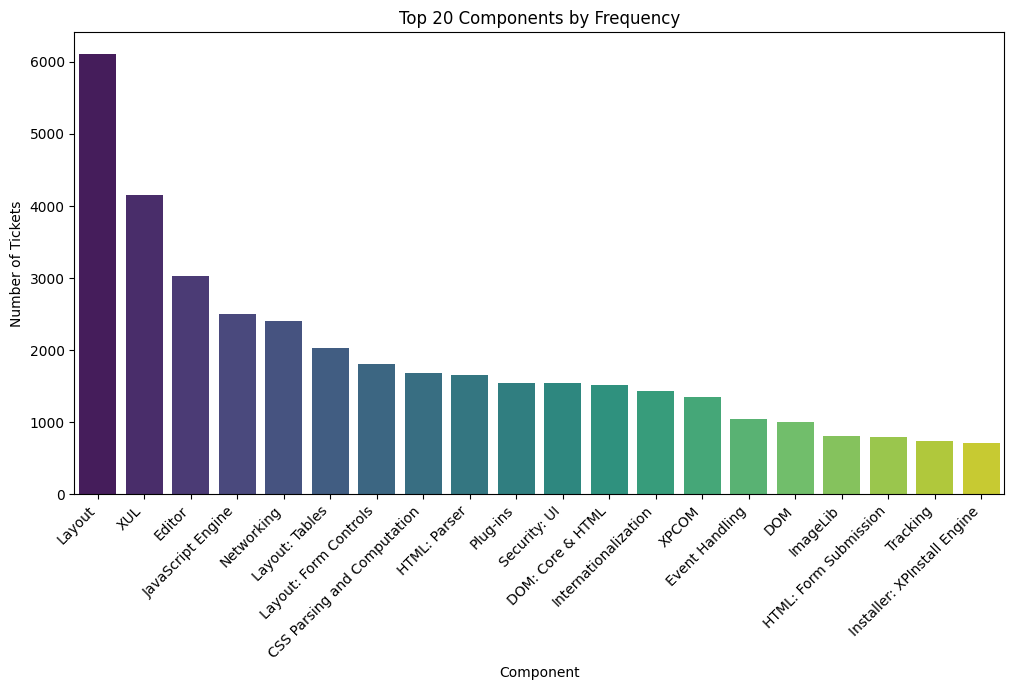

In [284]:
top_components = component_counts.head(20)
plt.figure(figsize=(12,6))
sns.barplot(
  x=top_components.index, 
  y=top_components.values,
  hue=top_components.index,
  palette="viridis",
  dodge=False
)
plt.title("Top 20 Components by Frequency")
plt.xlabel("Component")
plt.ylabel("Number of Tickets")
plt.xticks(rotation=45, ha="right")
plt.show()

In [285]:
component_ct = pd.crosstab(train_df["Component"], train_df["Priority"])
component_ct_percentage = component_ct.div(component_ct.sum(axis=1), axis=0)
component_ct_percentage

Priority,0,1,2,3,4
Component,,,,,
Account Manager,0.518519,0.185185,0.222222,0.037037,0.037037
Address Book,0.272727,0.090909,0.454545,0.090909,0.090909
Bookmarks & History,0.016216,0.394595,0.304505,0.219820,0.064865
Build Config,0.343373,0.307229,0.222892,0.036145,0.090361
CSS Parsing and Computation,0.132187,0.235922,0.545347,0.066390,0.020154
...,...,...,...,...,...
XUL,0.104959,0.116273,0.722677,0.039961,0.016129
jemalloc,1.000000,0.000000,0.000000,0.000000,0.000000
js-ctypes,0.789474,0.105263,0.105263,0.000000,0.000000


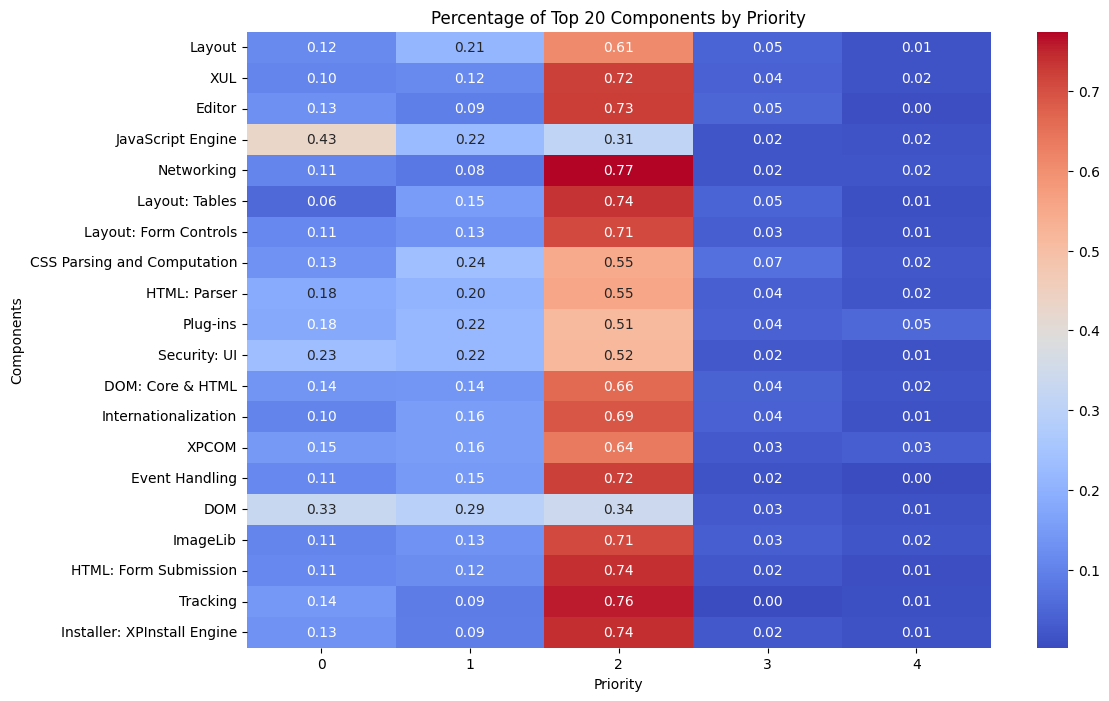

In [286]:
component_ct_top = component_ct_percentage.loc[top_components.index]

plt.figure(figsize=(12,8))
sns.heatmap(component_ct_top, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Percentage of Top 20 Components by Priority")
plt.ylabel("Components")
plt.xlabel("Priority")
plt.show()

In [287]:
def clean_component(comp):
  comp = str(comp).strip()
  comp = re.sub(r"[: ]", ":", comp)
  
  if ":" in comp:
    return comp.split(":")[0].strip()
  else:
    return comp.strip()

In [288]:
train_df["Component"] = train_df["Component"].apply(clean_component)

In [289]:
train_df["Component"].unique

<bound method Series.unique of 0            Layout
1          Plug-ins
2             XPCOM
3               XUL
4        Networking
            ...    
52989          Team
52990           CSS
52991     Migration
52992           DOM
52993      Panorama
Name: Component, Length: 52767, dtype: object>

In [290]:
component_counts = train_df["Component"].value_counts()
component_counts

Component
Layout        11365
XUL            4154
Networking     3863
Editor         3025
DOM            3020
              ...  
Filters           1
Find              1
Doc               1
mach              1
Instant           1
Name: count, Length: 114, dtype: int64

In [291]:
rare_components = component_counts[component_counts < 50].index
rare_components

Index(['User', 'Toolbars', 'Drag', 'Message', 'Tabbed', 'Scripting',
       'Migration', 'Menus', 'Search', 'XForms', 'Image', 'Location',
       'Spelling', 'Account', 'Shell', 'Microsummaries', 'js-ctypes',
       'Geolocation', 'Compare', 'Downloads', 'SocialAPI', 'Folder', 'RSS',
       'Nanojit', 'IPC', 'XP', 'PDF', 'Webapp', 'Address', 'X-remote', 'GFX',
       'SWT', 'Help', 'Resources', 'Theme', 'SQL', 'Debug', 'Identity', 'Page',
       'Text', 'Permission', 'Session', 'MFBT', 'jemalloc', 'Phishing',
       'Extension', 'Private', 'OS', 'Gecko', 'Shumway', 'Hardware', 'Testing',
       'DMD', 'mozglue', 'Panning', 'FileLink', 'Filters', 'Find', 'Doc',
       'mach', 'Instant'],
      dtype='object', name='Component')

In [292]:
train_df["Component"] = train_df["Component"].replace(rare_components, "Other")

In [297]:
train_df.columns

Index(['Issue_id', 'Component', 'Title', 'Description', 'Status', 'Resolution',
       'Priority', 'Text'],
      dtype='object')

In [ ]:
processed_df = train_df[["Text", "Component", "Status", "Resolution", "Priority"]].copy()

## Save Processed Data

In [294]:
joblib.dump(processed_df, '../../data/processed/processed_ISEC_train_df.joblib')
print("Processed DataFrame saved successfully!")

Processed DataFrame saved successfully!


In [295]:
loaded_df = joblib.load('../../data/processed/processed_ISEC_train_df.joblib')
loaded_df.head()

,Text,Component,Priority
0,font size 9px rounded down to 8px {font} {ll} There is a piece of code in the Windows GFX that rounds the font size in the; same way as Netscape 4.X. The problem is that this code ends up rounding...,Layout,0
1,Land OOP plugins in mozilla-central (preffed off) We need to land OOP plugins in mozilla-central; preffed off by default. There are some blockers well need to deal with first.,Plug-ins,0
2,XP-COM Proxy code crashes when trying to AutoProxy parameters without a typelibrary (This bug imported from BugSplat; Netscapes internal bugsystem. It; was known there as bug #358181; http://scop...,XPCOM,0
3,crash setting display:none on grid rows [@ nsGrid::GetPrefRowHeight] User-Agent: Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.8b5) Gecko/20051017 Firefox/1.4.1; Build Identifier: Moz...,XUL,0
4,limit the memory cache to a reasonable value I have 1GB of RAM; so Im using 31MB of memory cache (b/c of the changes in bug; 105344). But it takes a very long time to actually fill up 31MB of memo...,Networking,0


## Key Findings
- Most bug reports are Priority 2 or 3.
- Text length 95th percentile is ~296 words, used for token truncation.
- Components like "Layout" and "JavaScript Engine" have higher Priority 0-1 ratios.
- Long-tail components were grouped into "Other" to avoid sparse categories.

## Next Step
Train a BERT classifier that takes `Text` and `Priority` as primary input features and `Component` for experimental model.